
# Data and computations for paper 

Lars G. Johnsen
National Library of Norway

In [55]:
import dhlab.nbtext as nb
import dhlab.module_update as mu
mu.update('collocations')
from collocations import dist_coll_urn, urn_coll, calculate_midpoint, dist
import pandas as pd

Updated file `C:\Users\yoons\Documents\GitHub\newspapers_coll_conc\collocations.py`

In [2]:
def df_jaccard(df, col1, col2, number=100, asc=False):
    s1 = df.sort_values(by=col1, ascending=asc)[:number].index
    s2 = df.sort_values(by=col2, ascending=asc)[:number].index
    
    #print(len(set(s1)&set(s2)))
    
    return jaccard(s1, s2)

In [48]:
dist_coll_urn??

In [25]:
def jaccards(s1, s2):
    return len(set(s1)&set(s2)),len(set(s1)|set(s2))

In [3]:
def jaccard(s1, s2):
    return len(set(s1)&set(s2))/len(set(s1)|set(s2))

In [90]:
def large_corpus_dist_coll(collword, urns = None, after= 10, before = 0, n = 300):
    colls_freq = []
    colls_dist = []
    coll = pd.DataFrame()
    for i in range(0, len(urns), n):
        a = urn_coll(collword, urns = urns[i:i + n], after= after, before = before)
        colls_freq.append(nb.frame(a['freq']))
        colls_dist.append(nb.frame(a['dist']))
    coll['freq'] = pd.concat(colls_freq, axis=1, sort=False).sum(axis=1)
    coll['dist'] = pd.concat(colls_dist, axis = 1, sort=False).mean(axis=1)
    coll['dist_score'] = round(dist(coll['dist'], calculate_midpoint(before, after), coll['freq']), 2)
    return coll

In [4]:
def large_corpus_coll(collword, urns = None, after= 5, before = 5, n = 300):
    colls = []
    for i in range(0, len(urns), n):
        colls.append(nb.urn_coll(collword, urns=urns[i:i + n], after= after, before = before))
    coll = pd.concat(colls, axis=1, sort=False).sum(axis=1)
    return pd.DataFrame(coll)

In [5]:
def make_coll_df(small, large, tot):
    """take two collocations, small and large, and a reference tot. The reference must av a column call tot as well"""
    coll = pd.DataFrame()
    coll['small'] = small['freq']
    coll['large'] = large['freq']
    #coll['ratio'] = coll['small']/coll['large']
    coll['srel'] = coll.small/coll.small.sum()
    coll['lrel'] = coll.large/coll.large.sum()
    coll['ratio'] = coll.srel/coll.lrel
    coll['adjusted'] = coll.small**0.01*coll.ratio
    coll['nb'] = coll.small/tot.tot
    return coll

### Reference corpus

The reference is the total counts from approximately 450 000 books from nb.no

In [6]:
tot = nb.frame(nb.totals(50000), 'tot')

In [7]:
nb.normalize_corpus_dataframe(tot)
tot.head()

,tot
.,0.058921
",",0.051453
og,0.025297
i,0.021425
det,0.012728


# Corpus

The corpus for doing collocations is a sample of 800 books from fictional literature, dewey decimal code 813.

In [142]:
smd = 5
lmd = 10
collword = 'kaffe'

In [143]:
corpus = nb.book_corpus(words=[collword], ddk="813%", period=(1980, 2000), limit = 5000)

In [144]:
print(len(corpus))
corpus.head()

3893


,urn,author,title,year
0,2008021800102,"Crais, Robert",Kidnappet,1995
1,2008012200005,"Nixon, Joan Lowery",Hvem kidnappet Christina Lattimore?,1994
2,2010102920012,"Grey, Zane",I præriens grep,1990
3,2016062048082,"Traylor, Ellen Gunderson",Mot ukjent land,1981
4,2013062808080,"Wolfe, Tom",Forfengelighetens fyrverkeri,1988


Set up the distance parameters and collword, smd is small distance while lmd is large distance. These values are half of the actual window, and used to make a normalized score, call ascore. See below.

In [145]:
a1 = nb.frame(large_corpus_dist_coll(collword, urns=list(corpus.urn), after= int(2*smd), before = 0), 'freq')
a2 = nb.frame(large_corpus_dist_coll(collword, urns=list(corpus.urn), after= int(2*lmd), before = 0), 'freq')

In [146]:
b1 = nb.frame(large_corpus_dist_coll(collword, urns=list(corpus.urn), after=0, before = int(2*smd)), 'freq')
b2 = nb.frame(large_corpus_dist_coll(collword, urns=list(corpus.urn), after=0, before = int(2*lmd)), 'freq')

In [172]:
a1 = a1.to_csv('kaffe_large_after.csv')
a2 = a2.to_csv('kaffe_small_after.csv')
b1 = b1.to_csv('kaffe_large_before.csv')
b2 = b2.to_csv('kaffe_small_before.csv')


## Create collocation dataframe 

Based on data from a1 and a2, and b1 and b2. The name for the collocations after is `coll` while `collb` is for the collocates coming before.

In [147]:
coll = make_coll_df(a1, a2, tot)
collb = make_coll_df(b1, b2, tot)

## Sorting 

Sorting on the reference is by column 'nb'

In [148]:
coll[coll.small > 1].sort_values(by='nb', ascending=False)[:20][:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kannen,119,150,0.000310851,0.000201807,1.54034,1.61574,1.16159e+08
rundstykker,120,141,0.000313463,0.000189699,1.65243,1.73346,1.15297e+08
koppen,434,718,0.00113369,0.000965983,1.17361,1.2471,8.6239e+07
koppene,102,141,0.000266444,0.000189699,1.40456,1.47105,7.63167e+07
Kaffen,68,115,0.000177629,0.000154719,1.14808,1.19756,6.66919e+07
smørbrød,204,227,0.000532888,0.000305401,1.74488,1.84018,6.274e+07
krus,170,261,0.000444073,0.000351144,1.26464,1.33129,5.70135e+07
bacon,146,187,0.00038138,0.000251586,1.5159,1.59336,5.33343e+07
konjakk,156,170,0.000407502,0.000228715,1.78171,1.87399,4.67208e+07
kruset,108,170,0.000282117,0.000228715,1.23349,1.29262,4.00183e+07


In [149]:
coll[coll.small < coll.large].sort_values(by='adjusted', ascending=False)[:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kaker,220,231,0.000574683,0.000310783,1.84914,1.95162,3.31447e+07
pappkrus,49,51,0.000127997,6.86144e-05,1.86546,1.93949,0
hamburger,22,23,5.74683e-05,3.09438e-05,1.85718,1.91549,0
sigarer,18,19,4.70195e-05,2.55622e-05,1.83941,1.89335,1.47742e+07
kantinen,18,19,4.70195e-05,2.55622e-05,1.83941,1.89335,1.69177e+07
mineralvann,32,34,8.35902e-05,4.57429e-05,1.82739,1.89183,2.27319e+07
likør,43,46,0.000112324,6.18875e-05,1.81498,1.88454,0
wienerbrød,119,129,0.000310851,0.000173554,1.79109,1.87877,0
konjakk,156,170,0.000407502,0.000228715,1.78171,1.87399,4.67208e+07
hjemmebakte,15,16,3.91829e-05,2.15261e-05,1.82025,1.87022,0


In [150]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
pappkrus,49,51,0.000127997,6.86144e-05,1.86546,1.93949,0
hamburger,22,23,5.74683e-05,3.09438e-05,1.85718,1.91549,0
kaker,220,231,0.000574683,0.000310783,1.84914,1.95162,3.31447e+07
kantinen,18,19,4.70195e-05,2.55622e-05,1.83941,1.89335,1.69177e+07
sigarer,18,19,4.70195e-05,2.55622e-05,1.83941,1.89335,1.47742e+07
mineralvann,32,34,8.35902e-05,4.57429e-05,1.82739,1.89183,2.27319e+07
morgenavisene,15,16,3.91829e-05,2.15261e-05,1.82025,1.87022,0
hjemmebakte,15,16,3.91829e-05,2.15261e-05,1.82025,1.87022,0
likør,43,46,0.000112324,6.18875e-05,1.81498,1.88454,0
travet,14,15,3.65707e-05,2.01807e-05,1.81216,1.86062,5.45022e+06


In [151]:
coll.loc[[',','.', 'og','eller', 'i', 'på']]

,small,large,srel,lrel,ratio,adjusted,nb
",",18944.0,34685.0,0.049485,0.046665,1.060450,1.170213,368178.269487
.,31254.0,57338.0,0.081642,0.077141,1.058335,1.173741,530438.301672
og,17299.0,28202.0,0.045188,0.037942,1.190971,1.313051,683823.030603
eller,1161.0,1668.0,0.003033,0.002244,1.351439,1.450256,422879.733476
i,6458.0,12673.0,0.016870,0.017050,0.989416,1.080139,301422.690406
på,6987.0,13751.0,0.018251,0.018500,0.986544,1.077853,728637.980800


# collb

In [152]:
collb[collb.small < collb.large].sort_values(by='adjusted', ascending=False)[:40].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
skjenket,2411,2452,0.006298,0.00330741,1.90421,2.05843,2.81719e+08
kopp,9276,9574,0.0242307,0.012914,1.87631,2.05579,6.61987e+08
drakk,3808,3920,0.00994723,0.00528754,1.88126,2.04294,1.36923e+08
skjenkét,200,201,0.000522439,0.000271121,1.92696,2.03181,0
nytrukket,158,160,0.000412727,0.000215818,1.91238,2.01169,0
slurpet,101,102,0.000263832,0.000137584,1.91761,2.00818,0
enkét,133,135,0.000347422,0.000182096,1.9079,2.00352,0
rykende,307,315,0.000801943,0.000424891,1.88741,1.99865,1.15891e+08
traktet,142,145,0.000370932,0.000195585,1.89652,1.99288,0
skjenke,304,314,0.000794107,0.000423542,1.87492,1.98523,1.11914e+08


In [153]:
collb.sort_values(by='nb', ascending=False)[:40].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kopp,9276,9574,0.0242307,0.012914,1.87631,2.05579,6.61987e+08
kanne,654,686,0.00170837,0.000925319,1.84625,1.96991,3.55329e+08
skjenket,2411,2452,0.006298,0.00330741,1.90421,2.05843,2.81719e+08
krus,487,515,0.00127214,0.000694664,1.8313,1.94821,1.63327e+08
drakk,3808,3920,0.00994723,0.00528754,1.88126,2.04294,1.36923e+08
rykende,307,315,0.000801943,0.000424891,1.88741,1.99865,1.15891e+08
bestilte,717,806,0.00187294,0.00108718,1.72275,1.83983,1.14375e+08
skjenke,304,314,0.000794107,0.000423542,1.87492,1.98523,1.11914e+08
kopper,795,835,0.00207669,0.0011263,1.84382,1.97116,1.09306e+08
slurk,767,812,0.00200355,0.00109528,1.82927,1.9549,1.00637e+08


In [154]:
collb.sort_values(by='nb', ascending=False).loc[['sterk', 'kruttsterk']].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
sterk,487,516,0.00127214,0.000696012,1.82775,1.94443,4.91094e+06
kruttsterk,57,60,0.000148895,8.09317e-05,1.83976,1.91567,0


# coll

In [155]:
coll[coll.small == coll.large].sort_values(by='ratio', ascending=False)[:30].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
"(«Blodgørra»),",2,2,5.22439e-06,2.69076e-06,1.9416,1.95511,0
operere,1,1,2.61219e-06,1.34538e-06,1.9416,1.9416,170664
nonne,1,1,2.61219e-06,1.34538e-06,1.9416,1.9416,680316
notene,1,1,2.61219e-06,1.34538e-06,1.9416,1.9416,467033
nyrene,1,1,2.61219e-06,1.34538e-06,1.9416,1.9416,427317
nystett,1,1,2.61219e-06,1.34538e-06,1.9416,1.9416,0
nødvendigste,2,2,5.22439e-06,2.69076e-06,1.9416,1.95511,1.71305e+06
"nølende,",1,1,2.61219e-06,1.34538e-06,1.9416,1.9416,0
ofret,1,1,2.61219e-06,1.34538e-06,1.9416,1.9416,142275
oiriginaltegningen,1,1,2.61219e-06,1.34538e-06,1.9416,1.9416,0


In [156]:
coll.sort_values(by='nb', ascending=False)[:30].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kannen,119,150,0.000310851,0.000201807,1.54034,1.61574,1.16159e+08
rundstykker,120,141,0.000313463,0.000189699,1.65243,1.73346,1.15297e+08
koppen,434,718,0.00113369,0.000965983,1.17361,1.2471,8.6239e+07
koppene,102,141,0.000266444,0.000189699,1.40456,1.47105,7.63167e+07
Kaffen,68,115,0.000177629,0.000154719,1.14808,1.19756,6.66919e+07
smørbrød,204,227,0.000532888,0.000305401,1.74488,1.84018,6.274e+07
krus,170,261,0.000444073,0.000351144,1.26464,1.33129,5.70135e+07
bacon,146,187,0.00038138,0.000251586,1.5159,1.59336,5.33343e+07
konjakk,156,170,0.000407502,0.000228715,1.78171,1.87399,4.67208e+07
kruset,108,170,0.000282117,0.000228715,1.23349,1.29262,4.00183e+07


# jaccard similarity

compare over a range

In [163]:
rng = range(2,60,2)

# for collb

Text(0, 0.5, 'Jaccard score')

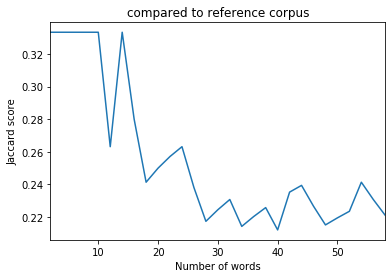

In [168]:
jaccard_scoresb = nb.frame({'ratio': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'adjusted', x) for x in rng},
                            'srel': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'srel', x) for x in rng},
                           'lrel': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'lrel', x) for x in rng}
                          }).transpose()

ax = jaccard_scoresb['ratio'].plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

# for coll

Text(0, 0.5, 'Jaccard score')

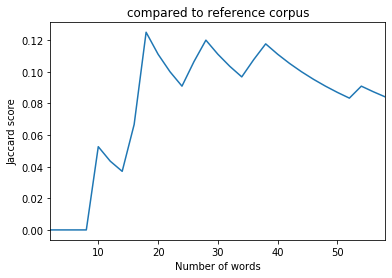

In [169]:
jaccard_scores = nb.frame({'ratio': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'adjusted', x) for x in rng},
                            'srel': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'srel', x) for x in rng},
                           'lrel': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'lrel', x) for x in rng}
                          }).transpose()

ax = jaccard_scores['ratio'].plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

In [162]:
jaccards(collb[collb.small < collb.large].sort_values(by='ratio', ascending = False)[:60].index, collb.sort_values(by='nb', ascending=False)[:100].index)

(23, 137)